In [1]:
from PIL import Image
import os
import numpy as np

dataset_path = "/kaggle/input/selfies2/Human Dataset/"

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')  # Convert to RGB
    img = img.resize(target_size)
    img_array = np.array(img)
    return img_array


# Load images and labels for training data
images = []
labels = []

for label, class_name in enumerate(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    
    # Ensure we process a limited number of images per class
    images_in_class = os.listdir(class_path)
    
    for image_name in images_in_class:
        image_path = os.path.join(class_path, image_name)
        
        # Load and preprocess the image
        img_array = load_and_preprocess_image(image_path)
        
        # Append the image and label
        images.append(img_array)
        labels.append(label)

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)



In [2]:
images.shape

(49, 224, 224, 3)

In [7]:
import matplotlib.pyplot as plt


# Function to plot sample images
def plot_sample_images(images, labels, class_names, num_samples=5):
    num_classes = len(class_names)
    
    # Create subplots for each class
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(num_samples * 2, num_classes * 2))
    fig.subplots_adjust(hspace=0.5)
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == i)[0]
        sample_indices = np.random.choice(class_indices, num_samples, replace=False)
        
        for j, sample_index in enumerate(sample_indices):
            axes[i, j].imshow(images[sample_index])
            axes[i, j].axis('off')
            axes[i, j].set_title(class_name)
    
    plt.show()

# Define class names based on the order of folders
class_names = sorted(os.listdir(dataset_path))

# Plot some sample images
plot_sample_images(images, labels, class_names)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    rescale=1./255  # Normalize pixel values to [0, 1]
)

augmented_images = []
augmented_labels = []

for j, singleImage in enumerate(images):
    img_array = singleImage.reshape((1,) + singleImage.shape)
    augmented_images.append(singleImage)
    augmented_labels.append(labels[j])
    for i, batch in enumerate(Datagen.flow(img_array, batch_size=1, save_to_dir=None, shuffle=False)):
        augmented_image = batch[0]
        augmented_images.append(augmented_image)
        augmented_labels.append(labels[j])

        if i >= 14:
            break

# Convert to NumPy arrays
augmented_images = np.asarray(augmented_images, dtype=np.float32)
augmented_labels = np.asarray(augmented_labels)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
augmented_images = (augmented_images * 255).astype(np.uint8)


In [10]:
augmented_images.shape

(784, 224, 224, 3)

In [12]:
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(augmented_images[1])
plt.title('Augmented Image')

plt.show()

In [13]:
pip install mtcnn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 8.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [14]:
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
import cv2  

# Create the detector
detector = MTCNN()

# Function to perform face detection and save detected faces
def detect_and_save_faces(images):
    detected_faces = []              # List to store the detected faces

    for image in images:
        # Detect faces in the image
        faces = detector.detect_faces(image)

        # Iterate through detected faces
        for face in faces:
            x, y, width, height = face['box']
            
            # Crop the detected face from the original image
            detected_face = image[y:y+height, x:x+width]
            
            # Resize the detected face to a common size
            detected_face_resized = cv2.resize(detected_face, (64, 64))
            
            # Append the resized detected face to the list
            detected_faces.append(detected_face_resized)

    return np.array(detected_faces)

# Apply face detection to your images
detected_faces = detect_and_save_faces(augmented_images)

1/1 [==============================] - 0s 21ms/step


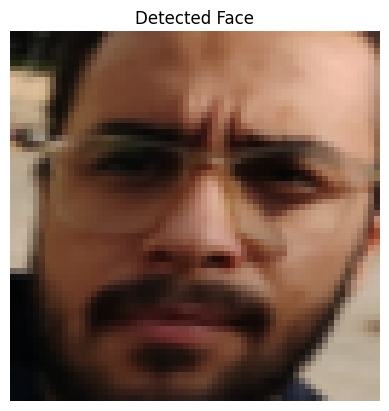

In [15]:
import matplotlib.pyplot as plt

# Visualize the original image and detected faces
plt.figure(figsize=(12, 6))
plt.imshow(images[0])
plt.title('Original Image')
plt.axis('off')
plt.show()

plt.imshow(detected_faces[1])
plt.title('Detected Face')
plt.axis('off')

plt.show()


In [16]:
detected_faces.shape

(754, 64, 64, 3)

In [17]:
import keras
from keras import layers
from keras.models import Model
from keras import backend as K



# VAE architecture
original_dim = 64 * 64 * 3  
intermediate_dim = 256
latent_dim = 20

# Encoder
inputs = keras.Input(shape=(64, 64, 3))  
h = layers.Flatten()(inputs)  
h = layers.Dense(intermediate_dim, activation='relu')(h)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

# Sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
x = layers.Dense(64 * 64 * 3, activation='sigmoid')(x)  # Change output shape
outputs = layers.Reshape((64, 64, 3))(x)  # Reshape to original shape

# creating encoder and decoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

# Loss function

# Binary cross-entropy loss for reconstruction
reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= original_dim

# KL divergence loss
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

# Compile the model
vae.compile(optimizer='adam')  
detected_faces = detected_faces / 255.0

# Training the model
history = vae.fit(detected_faces,detected_faces, epochs=100, batch_size=128)

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch 1/100
6/6 [==============================] - 3s 12ms/step - loss: 10123.1201
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 9574.2314
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 8851.5771
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 8423.6523
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 8289.8838
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 8213.9619
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 8170.8418
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 8135.4336
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 8090.5610
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 8044.1406
Epoch 11/100
6/6 [==============================] - 0s 9ms/step - loss: 7994.7266
Epoch 12/100
6/6 [==============================] - 0s 9ms/step - loss: 7957.8657
Epoch 13/100
6/6 

In [ ]:
vae.summary()

# **Reconstruction for original images**

In [18]:
# reconstructed images from detected_faces
reconstructed_images = vae.predict(detected_faces)
reconstructed_images = np.clip(reconstructed_images, 0, 1)



24/24 [==============================] - 0s 2ms/step


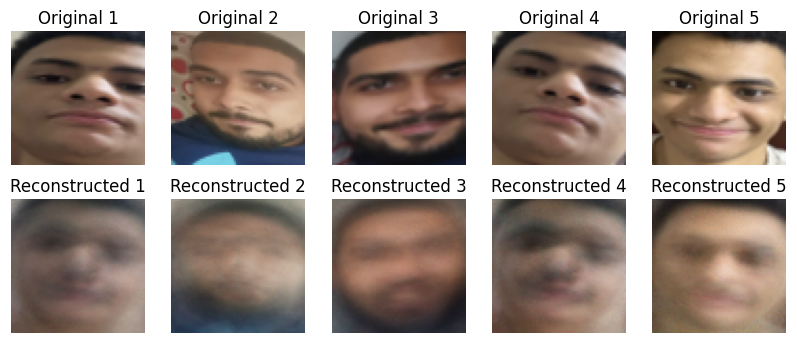

In [19]:
import matplotlib.pyplot as plt

# random indices for plotting
indices = np.random.choice(len(detected_faces), size=5, replace=False)

# Plot original and reconstructed images 
plt.figure(figsize=(10, 4))
for i, index in enumerate(indices):
    # Plot original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(detected_faces[index])
    plt.axis('off')
    plt.title(f'Original {i + 1}')

    # Plot reconstructed image
    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[index])
    plt.axis('off')
    plt.title(f'Reconstructed {i + 1}')

plt.show()


# **Reconstruction for Generated images**

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate images from the VAE model
def generate_and_reconstruct_images(vae_model, num_samples=5):
    # Generate random samples in the latent space
    random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
    
    # Decode the latent vectors to generate new images
    generated_images = vae_model.layers[2].predict(random_latent_vectors)  
    
    # Reconstruct the generated images
    reconstructed_images = vae_model.predict(generated_images)

    # Clip pixel values to valid range [0, 1]
    generated_images = np.clip(generated_images, 0, 1)
    reconstructed_images = np.clip(reconstructed_images, 0, 1)

    return generated_images, reconstructed_images

generated_images, reconstructed_images = generate_and_reconstruct_images(vae)

# Plot the generated and reconstructed images side by side
plt.figure(figsize=(12, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(2, generated_images.shape[0], i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
    plt.title(f'Generated {i + 1}')

    plt.subplot(2, generated_images.shape[0], i + 1 + generated_images.shape[0])
    plt.imshow(reconstructed_images[i])
    plt.axis('off')
    plt.title(f'Reconstructed {i + 1}')

plt.show()


1/1 [==============================] - 0s 21ms/step
